### Book chapters

In Chapter 3 Section 2 the cable equation is derived and compartmental models are introduced.

### Python classes

The cable_equation.passive_cable module implements a passive cable using a Brian2 multicompartment model. To get started, import the module and call the demo function:

In [1]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex.cable_equation import passive_cable
from neurodynex.tools import input_factory

The function `passive_cable.getting_started()` injects a very short pulse current at (t=500ms, x=100um) into a finite length cable and then lets Brian evolve the dynamics for 2ms. This simulation produces a time x location matrix whose entries are the membrane voltage at each (time,space)-index. The result is visualized using pyplot.imshow.

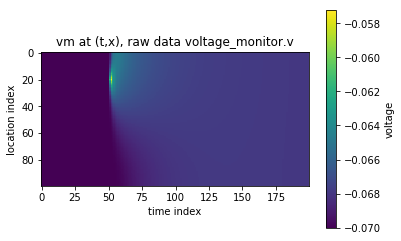

In [2]:
passive_cable.getting_started()

The axes in the figure above are not scaled to the physical units but show the raw matrix indices. These indices depend on the spatial resolution (number of compartments) and the temporal resolution (brian2.defaultclock.dt). For the exercises make sure you correctly scale the units using Brian’s unit system . As an example, to plot voltage vs. time you call

```python
pyplot.plot(voltage_monitor.t / b2.ms, voltage_monitor[0].v / b2.mV)
```
This way, your plot shows voltage in mV and time in ms, which is useful for visualizations. Note that this scaling (to physical units) is different from the scaling in the theoretical derivation (e.g. chapter 3.2.1 where the quantities are rescaled to a unit-free characteristic length scale

## 5.1. Exercise: spatial and temporal evolution of a pulse input
Create a cable of length 800um and inject a 0.1ms long step current of amplitude 0.8nanoAmp at (t=1ms, x=200um). Run Brian for 3 milliseconds.

You can use the function `cable_equation.passive_cable.simulate_passive_cable()` to implement this task. For the parameters not specified here (e.g. dentrite diameter) you can rely on the default values. Have a look at the documentation of `simulate_passive_cable()` and the source code of `passive_cable.getting_started()` to learn how to efficiently solve this exercise. From the specification of `simulate_passive_cable()` you should also note, that it returns two objects which are helpful to access the values of interest using spatial indexing:

```python
voltage_monitor, cable_model = passive_cable.simulate_passive_cable(...)
probe_location = 0.123 * b2.mm
v = voltage_monitor[cable_model.morphology[probe_location]].v
```

In [3]:
probe_location = 200 * b2.um
step_current = input_factory.get_step_current(1000, 1100, unit_time=b2.us, amplitude=0.8*b2.namp)
voltage_monitor, cable_model = passive_cable.simulate_passive_cable(input_current=step_current, 
                                                                    length=800*b2.um, current_injection_location=[probe_location], simulation_time=3*b2.ms)
v = voltage_monitor[cable_model.morphology[probe_location]].v

### 5.1.1. Question:
1. What is the maximum depolarization you observe? Where and when does it occur?
2. Plot the temporal evolution (t in [0ms, 3ms]) of the membrane voltage at the locations 0um, 100um, … , 600 um in one figure.
3. Plot the spatial evolution (x in [0um, 800um]) of the membrane voltage at the time points 1.0ms, 1.1ms, … , 1.6ms in one plot
4. Discuss the figures.

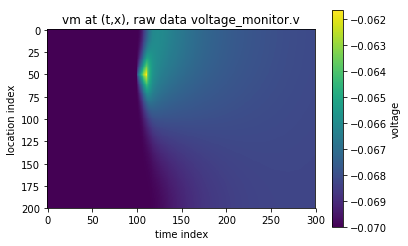

In [4]:
# Source code for neurodynex.cable_equation.passive_cable
def plot_getting_started(current, voltage_monitor, cable_model):
    """
    A simple code example to get started.
    """
    # provide a minimal plot
    plt.figure()
    plt.imshow(voltage_monitor.v / b2.volt)
    plt.colorbar(label="voltage")
    plt.xlabel("time index")
    plt.ylabel("location index")
    plt.title("vm at (t,x), raw data voltage_monitor.v")
    plt.show()

plot_getting_started(step_current, voltage_monitor, cable_model)

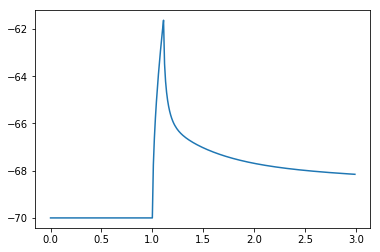

In [5]:
plt.plot(voltage_monitor.t / b2.ms, v / b2.mV)

In [6]:
max_idx = np.argmax(v / b2.mV)
max_time = (voltage_monitor.t / b2.ms)[max_idx]
max_time

1.11

**The maximum depolarization occurs at 111us in 200um**

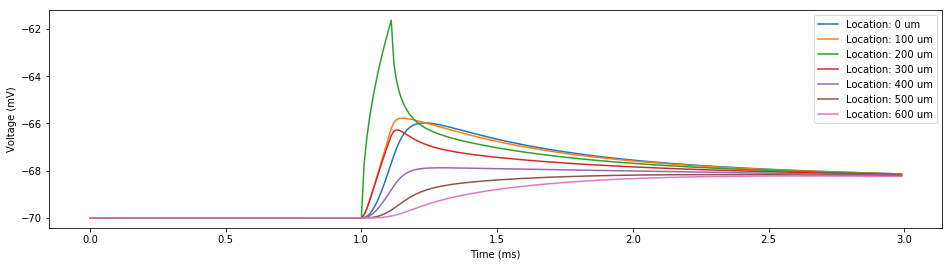

In [7]:
plt.figure(figsize=(16, 4))
for i in range(7):
    probe_location = 100 * i * b2.um
    v = voltage_monitor[cable_model.morphology[probe_location]].v
    plt.plot(voltage_monitor.t / b2.ms, v / b2.mV, label='Location: %s um' % (100 * i))
    plt.legend()
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
plt.show()

In [8]:
# The state monitor contains the membrane voltage in a Time x Location matrix.
voltage_monitor.v.shape

(200L, 300L)

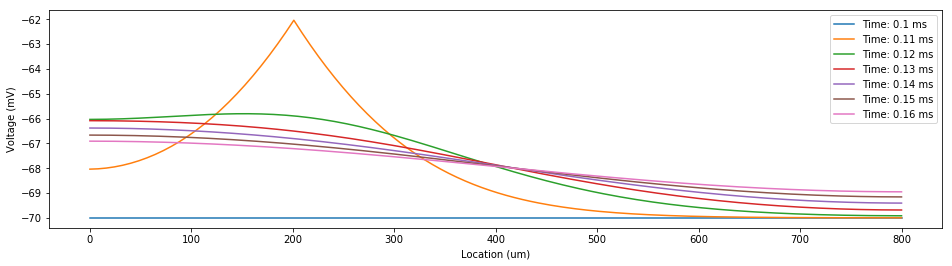

In [9]:
plt.figure(figsize=(16, 4))
spatial = np.linspace(0, 800, 200)
for i in range(100,161,10):
    probe_time = i * b2.us
    v = voltage_monitor.v[:, i]
    plt.plot(spatial, v / b2.mV, label='Time: %s ms' % (i / 1000.0))
    plt.legend()
    plt.xlabel("Location (um)")
    plt.ylabel("Voltage (mV)")
plt.show()

## 5.2. Exercise: Spatio-temporal input pattern
While the passive cable use here is a very simplified model of a real dendrite, we can still get an idea of how input spikes would look to the soma. Imagine a dendrite of some length and the soma at x=0um. What is the depolarization at x=0 if the dendrite receives multiple spikes at different time/space locations? This is what we study in this exercise:

**Create a cable of length 800uM and inject three short pulses A, B, and C at different time/space locations:**

    A: (t=1.0ms, x=100um)
    B: (t=1.5ms, x=200um)
    C: (t=2.0ms, x=300um)
    Pulse input: 100us duration, 0.8nanoAmp amplitude
Make use of the function `input_factory.get_spikes_current()` to easily create such an input pattern:

WARNING    Group uses a dt of 10. us while TimedArray uses dt of 100. us [brian2.input.timedarray]


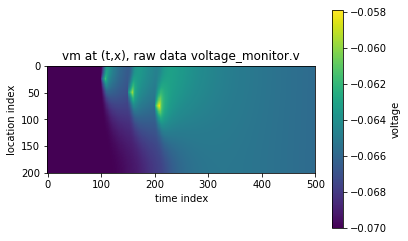

In [10]:
t_spikes = [10, 15, 20]
l_spikes = [100. * b2.um, 200. * b2.um, 300. * b2.um]
current = input_factory.get_spikes_current(t_spikes, 100*b2.us, 0.8*b2.namp, append_zero=True)
voltage_monitor_ABC, cable_model = passive_cable.simulate_passive_cable(current_injection_location=l_spikes, 
                                                                        length=800*b2.um, input_current=current, simulation_time=5*b2.ms)
plot_getting_started(current, voltage_monitor_ABC, cable_model)

### 5.2.1. Question
1. plot the temporal evolution (t in [0ms, 5ms]) of the membrane voltage at the soma (x=0). What is the maximal depolarization?
2. reverse the order of the three input spikes:

    C: (t=1.0ms, x=300um)
    
    B: (t=1.5ms, x=200um)
    
    A: (t=2.0ms, x=100um)
    
Again, let Brian simulate 5 milliseconds. In the same figure as before, plot the temporal evolution (t in [0ms, 5ms]) of the membrane voltage at the soma (x=0). What is the maximal depolarization? Discuss the result.

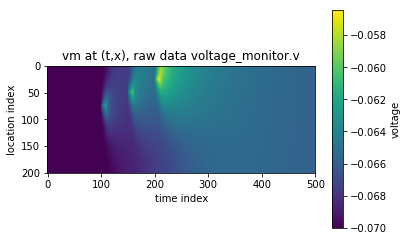

In [11]:
t_spikes = [10, 15, 20]
l_spikes = [300. * b2.um, 200. * b2.um, 100. * b2.um]
current = input_factory.get_spikes_current(t_spikes, 100*b2.us, 0.8*b2.namp, append_zero=True)
voltage_monitor_CBA, cable_model = passive_cable.simulate_passive_cable(current_injection_location=l_spikes, 
                                                                        length=800*b2.um, input_current=current, simulation_time=5*b2.ms)
plot_getting_started(current, voltage_monitor_CBA, cable_model)

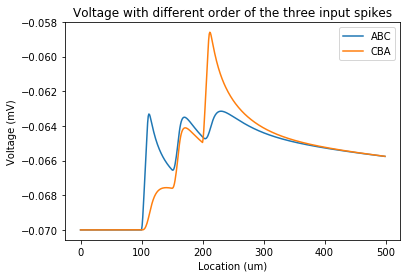

In [12]:
v_ABC = voltage_monitor_ABC[cable_model.morphology[0]].v
v_CBA = voltage_monitor_CBA[cable_model.morphology[0]].v
plt.figure()
plt.plot(v_ABC, label='ABC')
plt.plot(v_CBA, label='CBA')
plt.title("Voltage with different order of the three input spikes")
plt.legend()
plt.xlabel("Location (um)")
plt.ylabel("Voltage (mV)")
plt.show()

## 5.3. Exercise: Effect of cable parameters
So far, you have called the function `simulate_passive_cable()` without specifying the cable parameters. That means, the model was run with the default values. Look at the documentation of `simulate_passive_cable()` to see which parameters you can change.

Keep in mind that our cable model is very simple compared to what happens in dendrites or axons. But we can still observe the impact of a parameter change on the current flow. As an example, think of a myelinated fiber: it has a much **lower** membrane capacitance and **higher** membrane resistance. Let's compare these two parameter-sets:

### 5.3.1. Question
Inject a very brief pulse current at (t=.05ms, x=400um). Run Brian twice for 0.2 ms with two different parameter sets (see example below). Plot the temporal evolution of the membrane voltage at x=500um for the two parameter sets. Discuss your observations.

Note: to better see some of the effects, plot only a short time window and increase the temporal resolution of the numerical approximation (b2.defaultclock.dt = 0.005 * b2.ms)

In [13]:
b2.defaultclock.dt=0.005*b2.ms
pulse = input_factory.get_step_current(50, 50, unit_time=b2.us, amplitude=0.8*b2.namp)

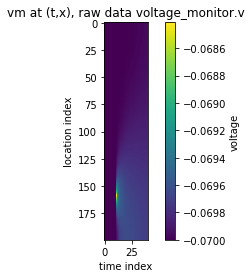

In [14]:
# set 1: (same as defaults)
membrane_resistance_1 = 1.25 * b2.Mohm * b2.mm ** 2
membrane_capacitance_1 = 0.8 * b2.uF / b2.cm ** 2
voltage_monitor_1, cable_model_1 = passive_cable.simulate_passive_cable(input_current=pulse,
                                                                        current_injection_location=[400*b2.um], simulation_time=0.2*b2.ms, 
                                                                        capacitance=membrane_capacitance_1, r_transversal=membrane_resistance_1)
plot_getting_started(pulse, voltage_monitor_1, cable_model_1)

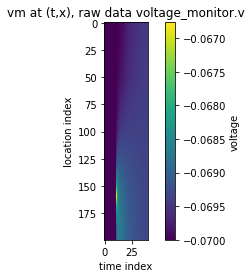

In [15]:
# set 2: (you can think of a myelinated "cable")
membrane_resistance_2 = 5.0 * b2.Mohm * b2.mm ** 2
membrane_capacitance_2 = 0.2 * b2.uF / b2.cm ** 2
voltage_monitor_2, cable_model_2 = passive_cable.simulate_passive_cable(input_current=pulse,
                                                                        current_injection_location=[400*b2.um], simulation_time=0.2*b2.ms, 
                                                                        capacitance=membrane_capacitance_2, r_transversal=membrane_resistance_2)
plot_getting_started(pulse, voltage_monitor_2, cable_model_2)

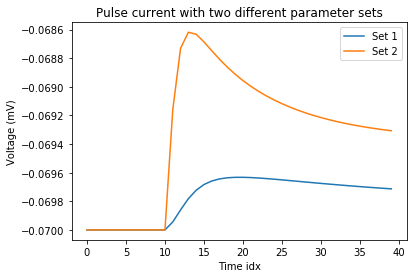

In [16]:
v1 = voltage_monitor_1[cable_model_1.morphology[-1]].v/b2.volt
v2 = voltage_monitor_2[cable_model_2.morphology[-1]].v/b2.volt

plt.plot(v1, label='Set 1')
plt.plot(v2, label='Set 2')
plt.title("Pulse current with two different parameter sets")
plt.legend()
plt.xlabel("Time idx")
plt.ylabel("Voltage (mV)")
plt.show()

## 5.4. Exercise: stationary solution and comparison with theoretical result
Create a cable of length 500um and inject a constant current of amplitude 0.1nanoAmp at x=0um. You can use the input_factory to create that current. Note the parameter append_zero=False. As we are not interested in the exact values of the transients, we can speed up the simulation increase the width of a timestep dt: b2.defaultclock.dt = 0.1 * b2.ms

In [17]:
b2.defaultclock.dt = 0.1 * b2.ms
current = input_factory.get_step_current(0, 0, unit_time=b2.ms, amplitude=0.1 * b2.namp, append_zero=False)

### 5.4.1. Question
Before running a simulation, sketch two curves, one for x=0um and one for x=500um, of the membrane potential Vm versus time. What steady state Vm do you expect?

Now run the Brian simulator for 100 milliseconds.

1. Plot Vm vs. time (t in [0ms, 100ms]) at x=0um and x=500um and compare the curves to your sketch.
2. Plot Vm vs location (x in [0um, 500um]) at t=100ms.

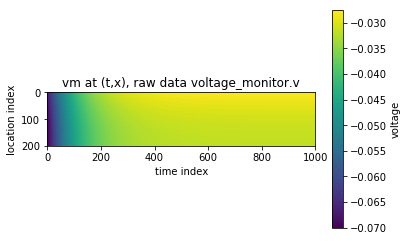

In [18]:
sim_time = 100 * b2.ms
voltage_monitor, cable_model = passive_cable.simulate_passive_cable(length=0.5 * b2.mm, current_injection_location = [0*b2.um],
                                                                    input_current=current, simulation_time=sim_time)
plot_getting_started(current, voltage_monitor, cable_model)

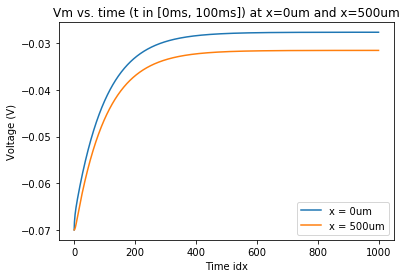

In [19]:
v_X0 = voltage_monitor.v[0,:]  # access the first compartment
v_Xend = voltage_monitor.v[-1,:]  # access the last compartment
plt.plot(v_X0, label='x = 0um')
plt.plot(v_Xend, label='x = 500um')
plt.legend()
plt.title("Vm vs. time (t in [0ms, 100ms]) at x=0um and x=500um")
plt.xlabel("Time idx")
plt.ylabel("Voltage (V)")
plt.show()

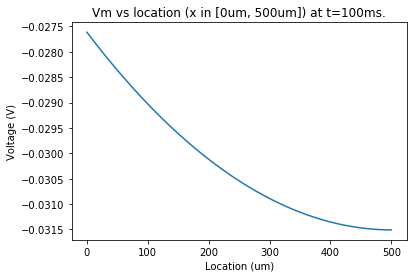

In [20]:
v_Tend = voltage_monitor.v[:, -1]  # access the last time step
spatial = np.linspace(0, 500, 200)
plt.plot(spatial, v_Tend)
plt.title("Vm vs location (x in [0um, 500um]) at t=100ms.")
plt.xlabel("Location (um)")
plt.ylabel("Voltage (V)")
plt.show()

### 5.4.2. Question
Compute the characteristic length λ (= length scale = lenght constant) of the cable. Compare your value with the previous figure.

$\lambda=\sqrt{\frac{r_{Membrane}}{r_{Longitudinal}}}$, where $r_L = R_L/(\pi·r^2)$ and $r_M=R_M/(2·\pi·r)$




In [21]:
r_M = passive_cable.R_TRANSVERSAL / (2 * np.pi * (passive_cable.CABLE_DIAMETER / 2))
r_L = passive_cable.R_LONGITUDINAL / (np.pi * (passive_cable.CABLE_DIAMETER / 2) ** 2)
lam = np.sqrt(r_M / r_L)
lam

1.11803399 * mmetre

### 5.4.3. Question (Bonus)
You observed that the membrane voltage reaches a location dependent steady-state value. Here we compare those simulation results to the analytical solution.

1. Derive the analytical steady-state solution. (finite cable length L, constant current I0 at x=0, sealed end: no longitudinal current at x=L).
2. Plot the analytical solution and the simulation result in one figure.
3. Run the simulation with different resolution parameters (change defaultclock.dt and/or the number of compartments). Compare the simulation with the analytical solution.
4. If you need help to get started, or if you’re not sure about the analytical solution, you can find a solution in the Brian2 docs :